In [1]:
import pysam
import os
import sys
from sys import getsizeof
import time

directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict,get_total_coverage_for_contig_at_position,\
print_read_info, update_coverage_array, get_read_information, get_hamming_distance

from utils import get_intervals, close_bam_filehandle_and_index_bam, write_rows_to_info_file, write_header_to_bam, \
write_read_to_bam_file, remove_file_if_exists, make_folder

import os, psutil
process = psutil.Process()
print(process.memory_info().rss/1000) 

101113.856


# An example on a bam for 875 cell barcodes (group0, group1, group2, group3, group4, group5, group6 split from the original bam)

### Should be about 875*30,000 = 26 million reads

#### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [2]:
bampath = '/projects/ps-yeolab3/ekofman/sailor2/data/groups_0_1_2_3_4_5_6_merged.bam'
samfile = pysam.AlignmentFile(bampath, "rb")

# Full test

In [12]:
def find_edits(bampath, contig, split_index, start, end, output_folder, verbose=False):
    samfile = pysam.AlignmentFile(bampath, "rb")
        
    counts = defaultdict(lambda:defaultdict(lambda:0))
    total_reads = 0
    
    bam_handles_for_barcodes = {}
    read_lists_for_barcodes = defaultdict(lambda:[])
    
    #print('Start: {}, End: {}'.format(start, end))
    reads_for_contig = samfile.fetch(contig, start, end, multiple_iterators=True, until_eof=True)

    output_file = '{}/{}_{}_{}_{}_edit_info.tsv'.format(edit_info_subfolder, contig, split_index, start, end)
    remove_file_if_exists(output_file)

    with open(output_file, 'w') as f:        
        write_header_to_bam(f)

        for i, read in enumerate(reads_for_contig):
            total_reads += 1
            
            if total_reads % 1000 == 0:
                if total_reads % 1000 == 0:
                    process = psutil.Process()
                    print("\t{}:{}-{} Total reads: {}, Memory: {}".format(contig, start, end, total_reads,
                                                                          process.memory_info().rss/1000))
                    pass
                    #print("\t{}:{}-{} Total reads: {}".format(contig, start, end, total_reads))
            

            barcode = read.get_tag("CB")
            barcodes[contig][barcode] += 1

            error_code, list_of_rows, num_edits_of_each_type = get_read_information(read, contig, verbose=verbose)

            if error_code:
                counts[contig][error_code] += 1
            else:
                counts[contig][EDITED_CODE] += 1
                write_rows_to_info_file(list_of_rows, f)

            bam_subfolder = "{}/{}_{}_{}_{}".format(split_bams_folder, contig, split_index, start, end)
            make_folder(bam_subfolder)

            # WRITE READ TO BAM FILE SPECIFIC TO THAT BARCODE AND THAT CONTIG
            barcode_bam_file_path = "{}/{}.bam".format(bam_subfolder, barcode)
            read_lists_for_barcodes[barcode_bam_file_path].append(read)
            
            
    for barcode_bam_file_path, read_list in read_lists_for_barcodes.items():
        bam_handle = pysam.AlignmentFile(barcode_bam_file_path, "wb", template=samfile)
        bam_handle.write(read)

    samfile.close()
    return bam_handles_for_barcodes, total_reads, barcodes, counts


def find_edits_and_split_bams(bampath, contig, split_index, start, end, output_folder, verbose=False):
    bam_handles_for_barcodes, total_reads, barcodes, counts = find_edits(bampath, contig, split_index,
                                                                         start, end, output_folder, verbose=verbose)
    
    print("bam handle size = {} kb".format(getsizeof(bam_handles_for_barcodes)/1000))
    # Index all subset bams
    for barcode_bam_file_path, bam_file_handle in bam_handles_for_barcodes.items():
        close_bam_filehandle_and_index_bam(bam_file_handle, barcode_bam_file_path)

    # Clear memory 
    del bam_handles_for_barcodes
    
    return total_reads, barcodes, counts
    
def find_edits_and_split_bams_wrapper(parameters):
    try:
        bampath, contig, split_index, start, end, output_folder, verbose = parameters
        label = '{}({}):{}-{}'.format(contig, split_index, start, end)

        #print("{} ({}):{}-{}\tfind_edits_and_split_bams".format(contig, split_index, start, end))
        total_reads, barcodes, counts = find_edits_and_split_bams(bampath, contig, split_index, start, end, output_folder, verbose=False)
        barcodes_df = pd.DataFrame.from_dict(barcodes)
        counts_df = pd.DataFrame.from_dict(counts)

        return total_reads, barcodes_df, label, counts_df
    except Exception as e:
        print('Contig {}: {}'.format(label, e))
        return 0, pd.DataFrame(), label, pd.DataFrame()

In [21]:
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time
from multiprocessing import Pool
import multiprocessing
from tqdm import tqdm

start_time = time.perf_counter()

print("CPU count: {}".format(multiprocessing.cpu_count()))

output_folder = '/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs'

contig_lengths_dict = get_contig_lengths_dict(samfile)

# Print info?
verbose = False 
EDITED_CODE = 'edited'
num_intervals = 1

num_reads_to_coverage_dict_kb = {}
num_reads_to_seconds = {}


start_time = time.perf_counter()
total_seconds_for_reads = {}

barcodes = defaultdict(lambda:defaultdict(lambda:0))

jobs = []
for contig in contig_lengths_dict.keys():
    if len(contig) > 5 or contig == 'Stamp':
        continue
        
    print("Contig {}".format(contig))
    contig_length = contig_lengths_dict.get(contig)
    intervals_for_contig = get_intervals(contig, contig_lengths_dict, num_intervals)

    edit_info_subfolder = '{}/edit_info'.format(output_folder)
    make_folder(edit_info_subfolder)
    
    split_bams_folder = '{}/split_bams'.format(output_folder)
    make_folder(split_bams_folder)
        
    # Set up for pool
    for split_index, interval in enumerate(intervals_for_contig):
        parameters = [bampath, contig, split_index, interval[0], interval[1], output_folder, verbose]
        jobs.append(parameters)
    
print("{} total jobs".format(len(jobs)))

# Pooling

results = []
overall_total_reads = 0
with Pool(processes=8) as p:
    max_ = len(jobs)
    with tqdm(total=max_) as pbar:
        for _ in p.imap_unordered(find_edits_and_split_bams_wrapper, jobs):
            pbar.update()
            results.append(_)
            
            total_reads = _[0]
            total_time = time.perf_counter() - start_time

            overall_total_reads += total_reads
            total_seconds_for_reads[overall_total_reads] = total_time

"""
for job in jobs:
    _ = find_edits_and_split_bams_wrapper(job)
    total_reads = _[0]
    total_time = time.perf_counter() - start_time

    overall_total_reads += total_reads
    total_seconds_for_reads[overall_total_reads] = total_time
"""

CPU count: 36
Contig 1
Contig 10
Contig 11
Contig 12
Contig 13
Contig 14
Contig 15
Contig 16
8 total jobs


  0%|          | 0/8 [00:00<?, ?it/s]

	16:0-98207768 Total reads: 1000, Memory: 151326.72
	12:0-120129022 Total reads: 1000, Memory: 151322.624
	1:0-195471971 Total reads: 1000, Memory: 151318.528
	11:0-122082543 Total reads: 1000, Memory: 151298.048	13:0-120421639 Total reads: 1000, Memory: 151289.856

	10:0-130694993 Total reads: 1000, Memory: 151293.952
	14:0-124902244 Total reads: 1000, Memory: 151322.624
	15:0-104043685 Total reads: 1000, Memory: 151293.952
	16:0-98207768 Total reads: 2000, Memory: 152203.264	12:0-120129022 Total reads: 2000, Memory: 152207.36

	1:0-195471971 Total reads: 2000, Memory: 152199.168	13:0-120421639 Total reads: 2000, Memory: 152199.168	11:0-122082543 Total reads: 2000, Memory: 152203.264

	10:0-130694993 Total reads: 2000, Memory: 152199.168
	14:0-124902244 Total reads: 2000, Memory: 152203.264
	15:0-104043685 Total reads: 2000, Memory: 152199.168

	16:0-98207768 Total reads: 3000, Memory: 152264.704
	12:0-120129022 Total reads: 3000, Memory: 152211.456	13:0-120421639 Total reads: 3000, M

 12%|█▎        | 1/8 [00:40<04:42, 40.43s/it]

bam handle size = 0.248 kb


 25%|██▌       | 2/8 [00:40<01:41, 16.95s/it]

bam handle size = 0.248 kb


 38%|███▊      | 3/8 [00:41<00:47,  9.43s/it]

bam handle size = 0.248 kb


 50%|█████     | 4/8 [00:41<00:23,  5.88s/it]

bam handle size = 0.248 kb


 62%|██████▎   | 5/8 [00:42<00:12,  4.14s/it]

bam handle size = 0.248 kb
bam handle size = 0.248 kb


 88%|████████▊ | 7/8 [00:44<00:02,  2.43s/it]

bam handle size = 0.248 kb


100%|██████████| 8/8 [00:48<00:00,  6.09s/it]


'\nfor job in jobs:\n    _ = find_edits_and_split_bams_wrapper(job)\n    total_reads = _[0]\n    total_time = time.perf_counter() - start_time\n\n    overall_total_reads += total_reads\n    total_seconds_for_reads[overall_total_reads] = total_time\n'

# Time profiling 

Text(0.5, 1.0, 'Runtime vs number of reads processed')

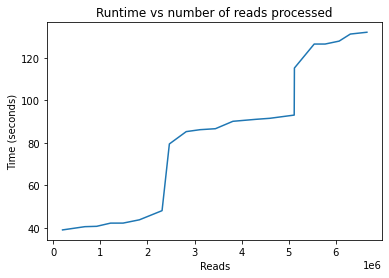

In [40]:
pd.DataFrame.from_dict(total_seconds_for_reads, orient='index').sort_index().plot(legend=False)
plt.xlabel("Reads")
plt.ylabel("Time (seconds)")
plt.title("Runtime vs number of reads processed")

In [41]:
rates = []
for reads, secs in zip(list(total_seconds_for_reads.keys()), list(total_seconds_for_reads.values())):
    rate = reads/secs
    rates.append(rate)

Average of 37438.70034769696 reads/second


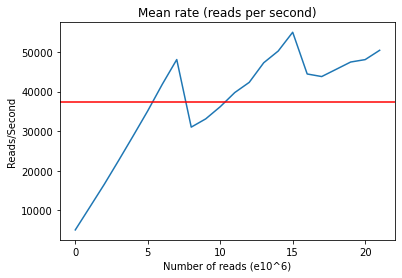

In [42]:
plt.plot(range(len(rates)), rates)
plt.title("Mean rate (reads per second)")
plt.ylabel("Reads/Second")
plt.xlabel("Number of reads (e10^6)")

average_rate = np.mean(rates)
plt.axhline(average_rate, color='r')
print("Average of {} reads/second".format(average_rate))

In [43]:
seconds_per_read = 1/average_rate

In [44]:
seconds_per_cell = seconds_per_read*50000

In [45]:
minutes_per_cell = seconds_per_cell/60

In [46]:
import math

reads_per_cell = 50000
total_cells = 20000
total_reads = reads_per_cell * total_cells
print(total_reads)

total_estimated_time = total_reads * seconds_per_read
print('Estimated total time in minutes for {} reads: {} minutes'.format(total_reads, math.ceil(total_estimated_time/60), 3))
print('Estimated total time in hours for {} reads: {} hours'.format(total_reads, math.ceil(total_estimated_time/3600), 3))
print("This can be split across contigs, to probably reduce to max 2-3 hours total with multiprocessing")

1000000000
Estimated total time in minutes for 1000000000 reads: 446 minutes
Estimated total time in hours for 1000000000 reads: 8 hours
This can be split across contigs, to probably reduce to max 2-3 hours total with multiprocessing


# Second loop to get coverage at sites with edits

In [47]:
from glob import glob

splits = [i.split("/")[-1] for i in glob('{}/split_bams/*'.format(output_folder))]
splits

['X_0_0_171031299',
 '4_0_0_156508116',
 '15_0_0_104043685',
 '3_0_0_160039680',
 'Y_0_0_91744698',
 'MT_0_0_16299',
 '7_0_0_145441459',
 '13_0_0_120421639',
 '19_0_0_61431566',
 '18_0_0_90702639',
 '12_0_0_120129022',
 '5_0_0_151834684',
 '16_0_0_98207768',
 '6_0_0_149736546',
 '17_0_0_94987271',
 '10_0_0_130694993',
 '9_0_0_124595110',
 '14_0_0_124902244',
 '11_0_0_122082543',
 '8_0_0_129401213',
 '2_0_0_182113224',
 '1_0_0_195471971']

In [50]:
all_edit_info_for_barcodes = []

for split in splits:
    contig = split.split("_")[0]
    print(split)
    reads_skipped = 0
    
    barcode_to_coverage_dict = defaultdict()    
    #contig_length = contig_lengths_dict.get(contig)
    
    barcode_to_coverage_dict = defaultdict()
    output_file = '{}/edit_info/{}_edit_info.tsv'.format(output_folder, split)
    edit_info = pd.read_csv(output_file, sep='\t')
    
    unique_barcodes = sorted(edit_info.barcode.unique())
    
    bam_subfolder = "{}/split_bams/{}".format(output_folder, split)

    for i, barcode in enumerate(unique_barcodes):
        if i % 100 == 0:
            print('{}/{}'.format(i, len(unique_barcodes)))
    
        barcode_bam = '{}/{}.bam'.format(bam_subfolder, barcode)
        if not os.path.exists('{}.bai'.format(barcode_bam)):
            pysam.index(barcode_bam)
        
        try:
            samfile_for_barcode = pysam.AlignmentFile(barcode_bam, "rb")

            edit_info_for_barcode = edit_info[edit_info.barcode == barcode]
            positions_for_barcode = edit_info_for_barcode.position.tolist()

            coverage = []
            for pos in positions_for_barcode:
                coverage_at_pos = np.sum(samfile_for_barcode.count_coverage(contig, pos-1, pos))
                coverage.append(coverage_at_pos)

            edit_info_for_barcode['coverage'] = coverage
            all_edit_info_for_barcodes.append(edit_info_for_barcode)
        except Exception as e:
            print(e)


    


X_0_0_171031299
0/875


/home/ekofman/new_anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
4_0_0_156508116
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
15_0_0_104043685
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
3_0_0_160039680
0/874
100/874
200/874
300/874
400/874
500/874
600/874
700/874
800/874
Y_0_0_91744698
0/314
100/314
200/314
300/314
MT_0_0_16299
0/869
100/869
200/869
300/869
400/869
500/869
600/869
700/869
800/869
7_0_0_145441459
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
13_0_0_120421639
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
19_0_0_61431566
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
18_0_0_90702639
0/869
100/869
200/869
300/869
400/869
500/869
600/869
700/869
800/869
12_0_0_120129022
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
5_0_0_151834684
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
16_0_0_98207768
0/875
100/875
2

In [51]:
all_edit_info = pd.concat(all_edit_info_for_barcodes)

In [52]:
all_edit_info['contig'] = all_edit_info.contig.astype(str)

In [53]:
all_edit_info = all_edit_info.drop_duplicates()

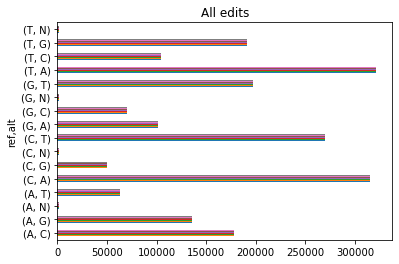

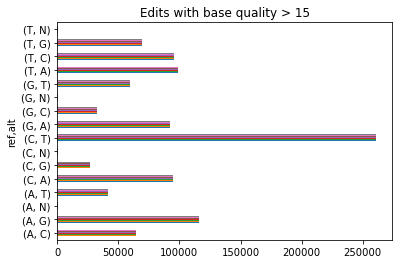

In [54]:
all_edit_info.groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
plt.title("All edits")

base_quality_thresh = 15
all_edit_info[all_edit_info.base_quality > base_quality_thresh].groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
plt.title("Edits with base quality > {}".format(base_quality_thresh))

all_edit_info_filtered = all_edit_info[all_edit_info.base_quality > base_quality_thresh]


In [55]:
example_new_ct =  all_edit_info_filtered[(all_edit_info_filtered.ref == 'C') & (all_edit_info_filtered.alt == 'T')].sort_values('position')

In [56]:
len(example_new_ct)

261260

In [57]:
example_new_ct

,barcode,contig,position,ref,alt,read_id,strand,dist_from_end,base_quality,coverage
61,AACAACCAGTAATACG-1,MT,2767,C,T,A01535:287:H3JJHDSX7:2:1273:15157:16094,+,17,37,0
8,AAACCCACACCGTGGT-1,MT,2794,C,T,A01535:287:H3JJHDSX7:1:2352:3640:34287,+,27,37,0
74,AACAAGACATTCGATG-1,MT,2802,C,T,A01535:287:H3JJHDSX7:1:2268:5791:28808,+,19,37,0
127,AAACGAACAGAACTTC-1,MT,2904,C,T,A01535:287:H3JJHDSX7:2:2424:26250:24502,+,8,37,0
148,AAAGTCCAGTCGGCCT-1,MT,2927,C,T,A01535:287:H3JJHDSX7:1:1151:26449:4492,+,49,37,0
...,...,...,...,...,...,...,...,...,...,...
94213,AAACCCACAAAGACGC-1,1,194961071,C,T,A01535:287:H3JJHDSX7:1:2106:16486:14356,+,3,37,0
94217,AACACACGTTTGTTCT-1,1,194961117,C,T,A01535:287:H3JJHDSX7:1:1278:24008:19742,+,28,37,0
94272,AAAGGATCATGAAGCG-1,1,195036921,C,T,A01535:287:H3JJHDSX7:1:2307:26910:7639,-,30,37,0
94279,AAAGGGCCACCAGTTA-1,1,195047095,C,T,A01535:287:H3JJHDSX7:1:2602:27670:19820,-,39,37,0


# Cells that do have STAMP expressed versus don't...?

In [58]:
stamp_expression_path = \
'/projects/ps-yeolab3/ekofman/Sammi/MouseBrainEF1A_SingleCell_EPR_combined/\
4.1_cells_with_middling_stamp/stamp_expression_for_all_used_cells.tsv'

In [59]:
stamp_expression_df = pd.read_csv(stamp_expression_path, sep='\t', index_col=0)

<AxesSubplot:>

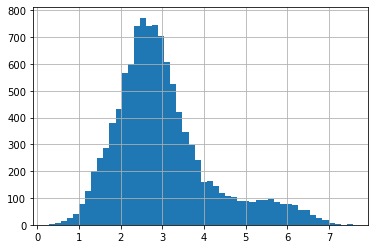

In [60]:
stamp_expression_df.Stamp.hist(bins=50)

0
1
2
3
4
5
6
6.5


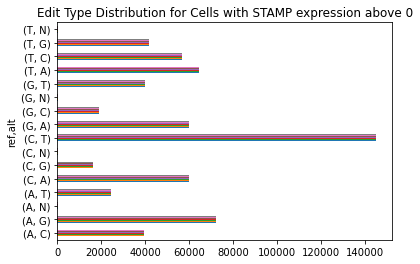

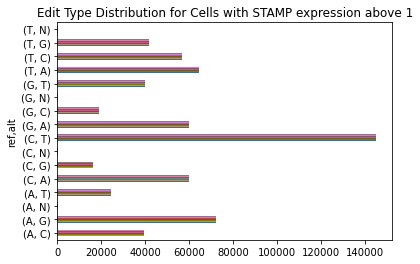

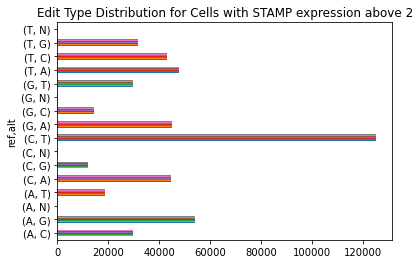

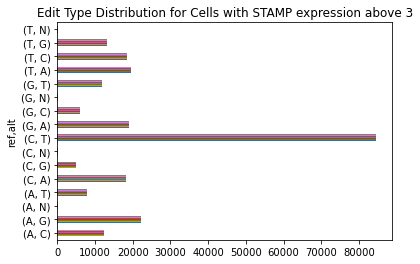

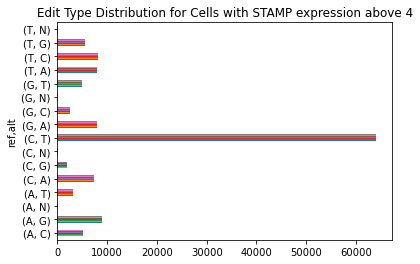

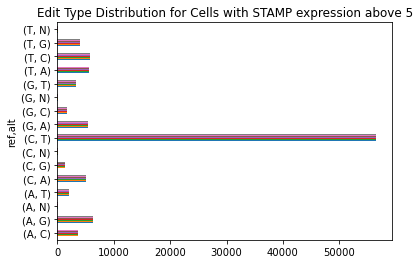

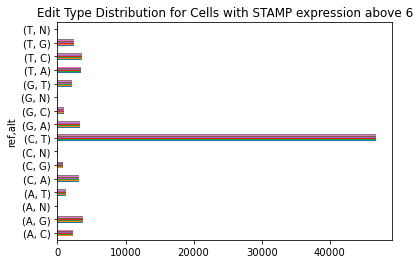

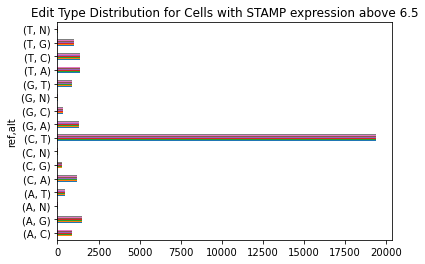

In [61]:
for thresh in [0, 1, 2, 3, 4, 5, 6, 6.5]:
    print(thresh)
    barcodes_at_stamp_thresh = stamp_expression_df[stamp_expression_df.Stamp > thresh].index
    
    all_edit_info_filtered[
        all_edit_info_filtered.barcode.isin(barcodes_at_stamp_thresh)].groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
    plt.title("Edit Type Distribution for Cells with STAMP expression above {}".format(thresh))

1.5
2
3
4
5
6


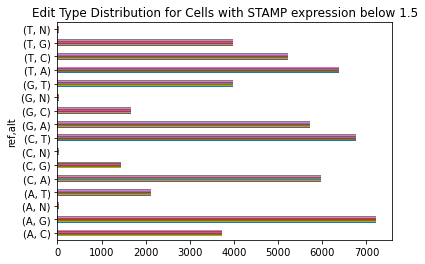

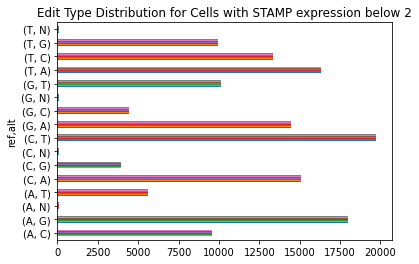

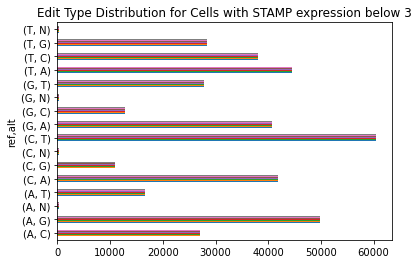

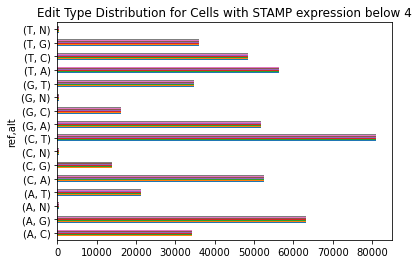

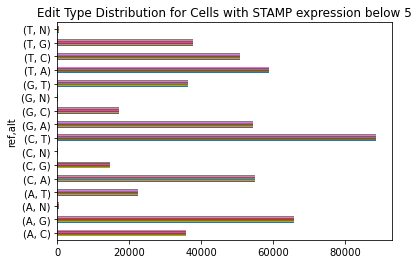

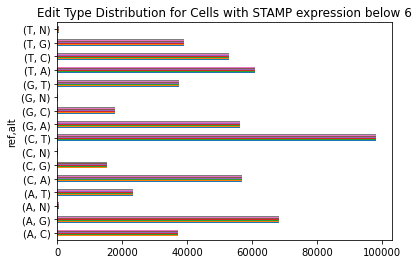

In [62]:
for thresh in [1.5,2, 3, 4, 5, 6]:
    print(thresh)
    barcodes_at_stamp_thresh = stamp_expression_df[stamp_expression_df.Stamp < thresh].index
    
    all_edit_info_filtered[
        all_edit_info_filtered.barcode.isin(barcodes_at_stamp_thresh)].groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
    plt.title("Edit Type Distribution for Cells with STAMP expression below {}".format(thresh))

# Extract only reads for a barcode

In [63]:
# Get edits for barcode
barcode = 'AAACCCAAGATTGCGG'


example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])


In [64]:

comparison_vals = []
overlapping_by_contig = {}
old_for_contig = {}
new_for_contig = {}
for contig in contigs:
    print('contig {}'.format(contig))
    example_new_ct_for_contig = example_new_ct[example_new_ct.contig == contig]
    example_new_ct_for_contig.index = example_new_ct_for_contig.position

    example_old_ct_for_contig = example[example.contig == contig]
    example_old_ct_for_contig.index = example_old_ct_for_contig.start

    old_for_contig[contig] = example_old_ct_for_contig
    new_for_contig[contig] = example_new_ct_for_contig
    # Which overlap?
    
    overlapping = example_old_ct_for_contig.join(example_new_ct_for_contig, rsuffix='_2', how='inner').drop_duplicates(['contig', 'start', 'end', 'score'])
    overlapping['old_coverage'] = [int(v.split(',')[1]) for v in overlapping['coverage']]
    overlapping_by_contig[contig] = overlapping
    print("\tNumber of sites in old version: {}".format(len(example_old_ct_for_contig)))
    print("\tNumber of sites recapitulated: {}".format(len(overlapping)))
    
    comparison_vals.append([len(example_old_ct_for_contig), len(overlapping), len(example_new_ct_for_contig)])


NameError: name 'contigs' is not defined

# Which sites are we recovering?

In [79]:
recapitulation_summary = pd.DataFrame(comparison_vals, index=contigs, columns=['Previous sites', 'Overlapping sites', 'New sites'])

Text(0.5, 1.0, 'Sites from old approach recapitulated with new approach')

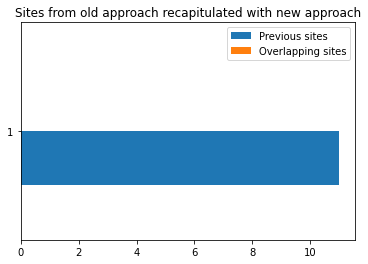

In [80]:
recapitulation_summary[['Previous sites', 'Overlapping sites']].head(22).plot(kind='barh')
plt.title("Sites from old approach recapitulated with new approach")

In [81]:
for contig in contigs:
    print(contig)
    corr = overlapping_by_contig.get(contig)[['old_coverage', 'coverage']].corr().iloc[0].iloc[0]
    print('\tCorrelation between old coverage and new coverage values: {}'.format(corr))

1
	Correlation between old coverage and new coverage values: nan
